In [97]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix

In [98]:
np.random.seed(0)
torch.manual_seed(0)

In [99]:
%matplotlib inline
sns.set_style('darkgrid')

In [100]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_dir = "images/"

In [101]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

In [102]:
dataset = datasets.ImageFolder(root = root_dir,
                                      transform = image_transforms["train"]
                                     )
dataset

Dataset ImageFolder
    Number of datapoints: 485
    Root location: images/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [103]:
dataset.class_to_idx

{'dense': 0, 'sparse': 1}

In [104]:
idx2class = {v: k for k, v in dataset.class_to_idx.items()}

Text(0.5, 1.0, 'Entire Dataset (before train/val/test split)')

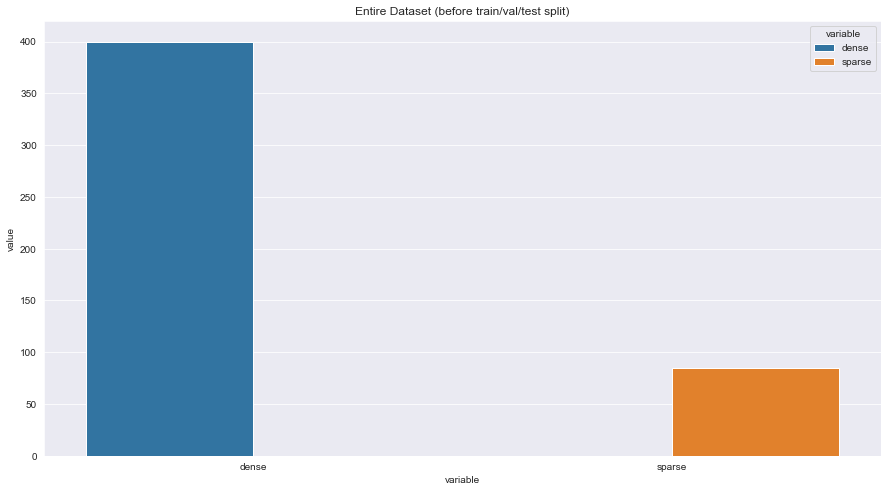

In [105]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict

def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)

plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(dataset), plot_title="Entire Dataset (before train/val/test split)")

In [106]:
dataset_size = len(dataset)
dataset_indices = list(range(dataset_size))

In [107]:
val_split_index = int(np.floor(0.2 * dataset_size))

In [108]:
train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [109]:
dataset_test = datasets.ImageFolder(root = "test",
                                            transform = image_transforms["test"]
                                           )
dataset_test

Dataset ImageFolder
    Number of datapoints: 401
    Root location: test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [110]:
train_loader = DataLoader(dataset=dataset, shuffle=False, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset=dataset, shuffle=False, batch_size=1, sampler=val_sampler)
test_loader = DataLoader(dataset=dataset, shuffle=False, batch_size=1)

In [111]:
def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    if dataloader_obj.batch_size == 1:    
        for _,label_id in dataloader_obj:
            y_idx = label_id.item()
            y_lbl = idx2class[y_idx]
            count_dict[str(y_lbl)] += 1
    else: 
        for _,label_id in dataloader_obj:
            for idx in label_id:
                y_idx = idx.item()
                y_lbl = idx2class[y_idx]
                count_dict[str(y_lbl)] += 1
    return count_dict

Text(0.5, 1.0, 'Val Set')

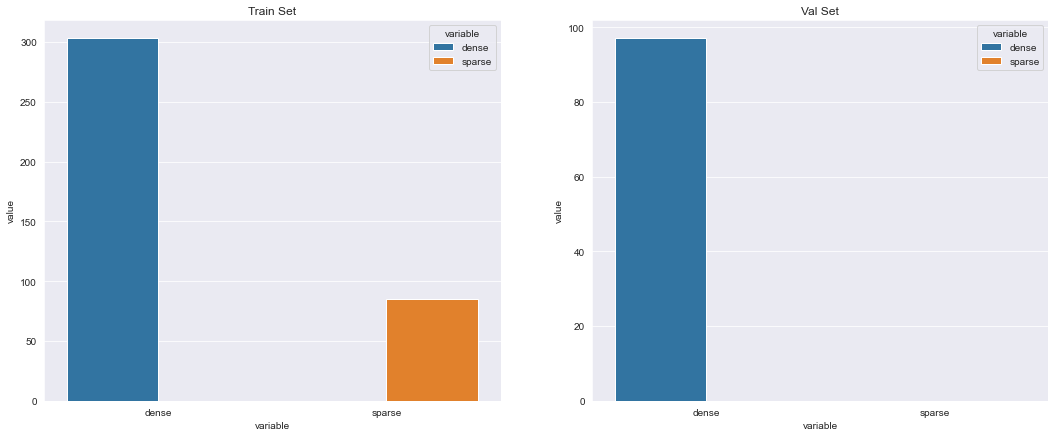

In [112]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
plot_from_dict(get_class_distribution_loaders(train_loader, dataset), plot_title="Train Set", ax=axes[0])
plot_from_dict(get_class_distribution_loaders(val_loader, dataset), plot_title="Val Set", ax=axes[1])

In [114]:
single_batch = next(iter(train_loader))
single_batch[0].shape
print("Output label tensors: ", single_batch[1])
print("\nOutput label tensor shape: ", single_batch[1].shape)

Output label tensors:  tensor([0, 0, 0, 1, 0, 0, 0, 0])

Output label tensor shape:  torch.Size([8])


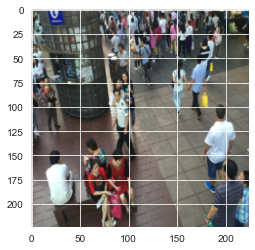

In [120]:
# Selecting the first image tensor from the batch. 
single_image = single_batch[0][0]
single_image.shape
plt.imshow(single_image.permute(1, 2, 0))

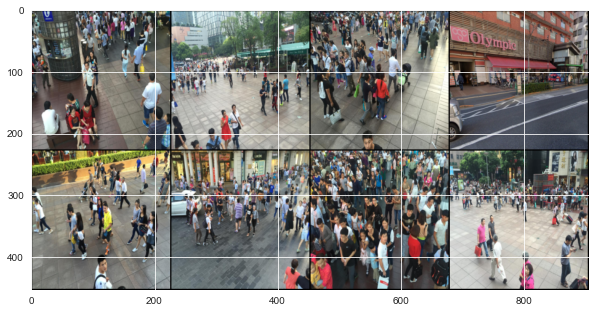

In [121]:
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)
plt.figure(figsize = (10,10))
plt.imshow(single_batch_grid.permute(1, 2, 0))

In [122]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.block1 = self.conv_block(c_in=3, c_out=256, dropout=0.1, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=56, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.maxpool(x)
        x = self.lastcnn(x)
        return x
    
    def conv_block(self, c_in, c_out, dropout,  **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        return seq_block

In [123]:
model = Classifier()
model.to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.008)

Classifier(
  (block1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (lastcnn): Conv2d(64, 2, kernel_size=(56, 56), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [124]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [125]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [126]:
print("Begin training.")
for e in tqdm(range(1, 21)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch).squeeze()
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch).squeeze()
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)
            val_epoch_loss += train_loss.item()
            val_epoch_acc += train_acc.item()
    
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.
Epoch 01: | Train Loss: 49.04672 | Val Loss: 0.00000 | Train Acc: 81.735| Val Acc: 100.000
Epoch 02: | Train Loss: 30.52330 | Val Loss: 60.03539 | Train Acc: 90.714| Val Acc: 75.000
Epoch 03: | Train Loss: 30.04309 | Val Loss: 0.00000 | Train Acc: 90.735| Val Acc: 100.000
Epoch 04: | Train Loss: 5.84368 | Val Loss: 0.00000 | Train Acc: 95.571| Val Acc: 100.000
Epoch 05: | Train Loss: 7.27659 | Val Loss: 46.67557 | Train Acc: 97.286| Val Acc: 75.000
Epoch 06: | Train Loss: 7.31398 | Val Loss: 0.00000 | Train Acc: 96.776| Val Acc: 100.000
Epoch 07: | Train Loss: 2.93258 | Val Loss: 0.00000 | Train Acc: 98.286| Val Acc: 100.000
Epoch 08: | Train Loss: 3.90468 | Val Loss: 0.00000 | Train Acc: 98.510| Val Acc: 100.000
Epoch 09: | Train Loss: 1.24399 | Val Loss: 0.00000 | Train Acc: 98.286| Val Acc: 100.000
Epoch 10: | Train Loss: 2.03362 | Val Loss: 0.00000 | Train Acc: 99.020| Val Acc: 100.000
Epoch 11: | Train Loss: 0.63372 | Val Loss: 0.00000 | Train Acc: 99.265| Val Acc:

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

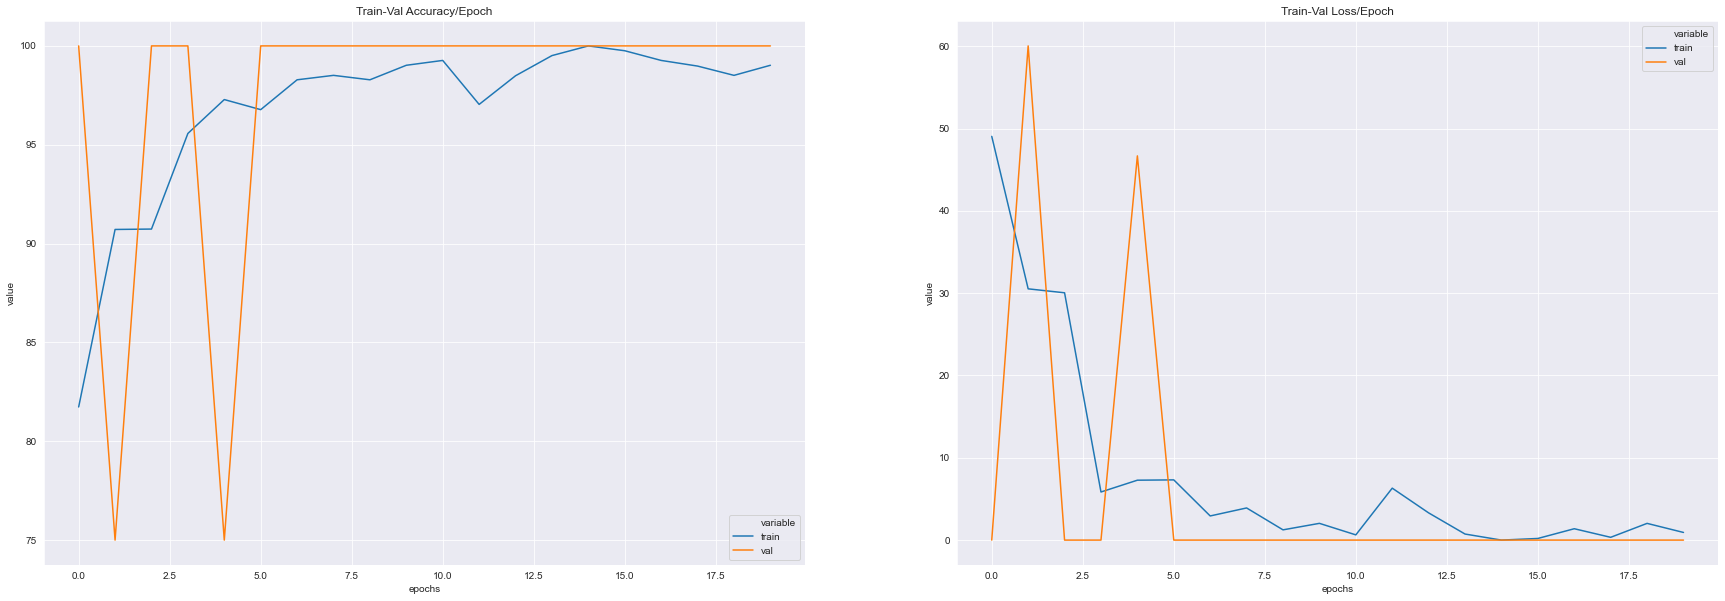

In [127]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [128]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [129]:
y_pred_list = [i[0][0][0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]
print(classification_report(y_true_list, y_pred_list))
print(confusion_matrix(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98       400
           1       0.83      1.00      0.90        85

    accuracy                           0.96       485
   macro avg       0.91      0.98      0.94       485
weighted avg       0.97      0.96      0.96       485

[[382  18]
 [  0  85]]


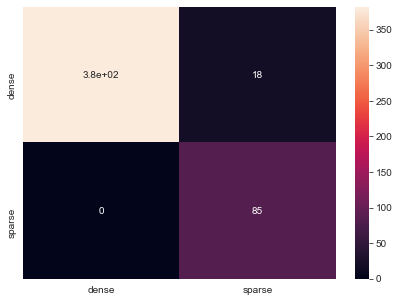

In [130]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)